# Exercise: Distributions of Spectra

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise involves calculating sample-based covariance matrices and visualizing the correlations they represent.   First import the dependencies.

In [27]:
import numpy as np
import pylab as plt
import figure_style

# Load wavelengths
wavelengths = np.loadtxt('data/wavelengths.txt')


We load the data file, and convert the data from Band-In-Line interleave, with index ordering of [rows, bands, columns], to Band-In-Pixel interleave, with index ordering of [rows, columns, bands].

In [28]:
filename = '../01_Introduction/data/ang20171108t184227_corr_v2p13_subset_bil'
rows, bands, cols = 500,425,680
mm = np.memmap(filename, dtype=np.float32, mode='r',shape=(rows,bands,cols))
X = np.asarray(mm,dtype = np.float32).copy().transpose((0,2,1))

We can now reshape it into a big contiguous list of spectra, i.e. a 2-D matrix of size [number of spectra] x [number of channels].  This will make the subsequent calculations much simpler because we will not have to loop over two spatial dimensions.  All calculations can be done in vector form.

In [29]:
X = X.reshape((rows*cols, bands))

As before, we zero out deep water features and regions with suspect calibration.

In [30]:
deeph2o = np.logical_or(np.logical_and(wavelengths>1280, wavelengths<1450),
                        np.logical_and(wavelengths>1750, wavelengths<2000))
badcalibration = wavelengths>2480
bad = np.logical_or(deeph2o, badcalibration)
X[:,bad] = 0

Watch out for values of -9999 in the data, which indicate the periphery of the rectangular geographically-registered image where the pushbroom sensor did not actually acquire data.  We ignore these locations.

In [31]:
use = np.all(X>-9900, axis=1)
X = X[use,:]

We don't require ALL the spectra to form our sample covariance matrix.  Here for speed I'll use every 40th spectrum in the list.  I calculate the sample mean and covariance using scipy's built-in functions, and plot the resulting covariance structure.  

<b> Question 1 </b> What do the block-diagonal structures that you see in the covariance represent, both mathematically and physically?

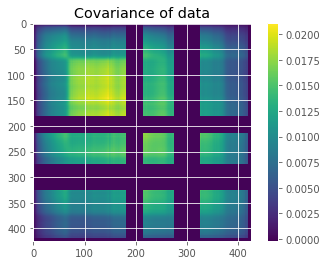

In [70]:
subsample = np.arange(0,X.shape[0],40)
Xsub = X[subsample,:]

mean = Xsub.mean(axis=0)
Cov  = np.cov(Xsub, rowvar=False)

plt.imshow(Cov)
plt.colorbar()
plt.title('Covariance of data')
plt.savefig('images/covariance.png')

Next we can sample from the multivariate Gaussian distribution using scipy's built in "multivariate_normal" sampler.  This generates spectra from the probability density we have fit.  Let's generate five samples.  If you get singular matrices, you may need a small regularization factor (1e-6 to 1e-8) added to the diagonal.


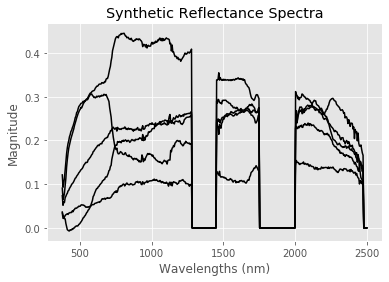

In [71]:
from scipy.stats import multivariate_normal

regularizer = 1e-8
Cov_regularized = Cov + np.eye(bands) * regularizer
n = multivariate_normal(mu, Cov_regularized)

for iteration in range(5):
    sample = n.rvs()
    plt.plot(wavelengths, sample, 'k')
    
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Magnitude')
plt.title('Synthetic Reflectance Spectra')
plt.savefig('images/synthetic_reflectance.png');


<b> Question 2 </b> Try sampling many times to get a feel for the spectra that are produced.  Comparing to the base image, do you think that a single multivariate Gaussian distribution is a good representation for the data? Why or why not?

In the second half of this exercise, we will try fitting a Gaussian to more specific subpopulations of spectra.  Specifically, we will look at vegetated and non-vegetated areas seperately.  We will classify pixels as vegetated and nonvegetated using the Normalized Difference Vegetation Index (https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), which measures the depth of the chlorophyll absorption feature. 

In [72]:
# Find indices corresponding to 650 nm (red) and 800 nm (near infrared).  Calculate NDVI
b800 = np.argmin(abs(wavelengths-800))
b650 = np.argmin(abs(wavelengths-650))
nir = X[:,b800]
red = X[:,b650]
ndvi = (nir - red) / (nir + red)

# Find subsets of data corresponding to vegetation and bare soil
veg = ndvi > 0.5
bare = ndvi < 0.1
X_veg = X[veg,:]
X_bare = X[bare,:]

# Calculate means and covariances for each subset independently
mean_veg = X_veg.mean(axis=0)
mean_bare = X_bare.mean(axis=0)
Cov_veg = np.cov(X_veg, rowvar=False)
Cov_veg = Cov_veg + np.eye(len(mu))*1e-8

Cov_bare = np.cov(X_bare, rowvar=False)
Cov_bare = Cov_bare + np.eye(len(mu))*1e-8

normal_bare = multivariate_normal(mu_bare, Cov_bare)
normal_veg = multivariate_normal(mu_veg, Cov_veg)

Now we can sample from the distribution of vegetated and non-vegetated spectra.

<b> Question 3 </b> How can we further improve the accuracy of our model, i.e. the realism of the resulting spectra?

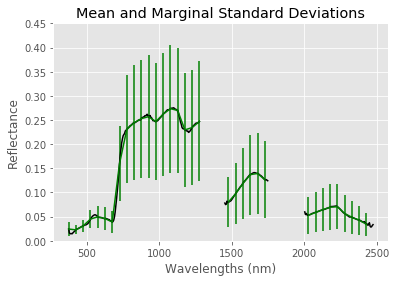

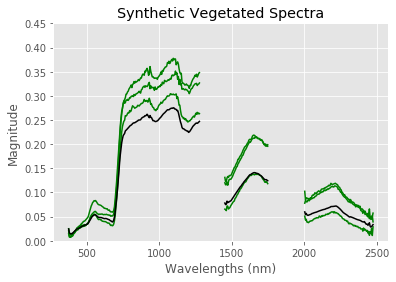

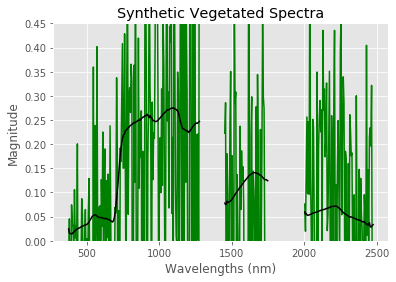

In [97]:
standard_dev = np.sqrt(np.diag(Cov_veg))
mean_veg[bad]=np.nan
standard_dev[bad]=np.nan

plt.figure(0)
skip = np.arange(0,len(mean_veg),10)
plt.errorbar(wavelengths[skip], mean_veg[skip],standard_dev[skip],color='g')
plt.plot(wavelengths, mean_veg, 'k')
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Reflectance')
plt.title('Mean and Marginal Standard Deviations')
plt.ylim([0,0.45])
plt.savefig('images/marginals.pdf')

plt.figure(1)
for iteration in range(3):
    
    sample = normal_veg.rvs()
    sample[bad] = np.nan
    plt.plot(wavelengths, sample, 'g')
    plt.xlabel('Wavelengths (nm)')
    plt.ylabel('Magnitude')
    plt.title('Synthetic Vegetated Spectra')
plt.ylim([0,0.45])
plt.plot(wavelengths, mean_veg, 'k')
plt.savefig('images/correlated_samples.pdf')

crazy_veg = multivariate_normal(mu_veg, np.eye(len(mu_veg))@np.sqrt(np.diag(Cov_veg)))
plt.figure(2)
for iteration in range(1):
    
    sample = crazy_veg.rvs()
    sample[bad] = np.nan
    plt.plot(wavelengths, sample, 'g')
    plt.xlabel('Wavelengths (nm)')
    plt.ylabel('Magnitude')
    plt.title('Synthetic Vegetated Spectra')
plt.ylim([0,0.45])
plt.plot(wavelengths, mean_veg, 'k')
plt.savefig('images/marginal_samples.pdf')

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.